<a href="https://colab.research.google.com/github/dane-meister/Machine-Learning-Algos/blob/main/monte_carlo_%26_q_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Monte Carlo and Q-Learning
Implements the RL algorithms listed as follows:
1. <b>Monte-Carlo</b> with a **tabular** state action value function
2. <b>Q-learning</b> with a **tabular** state action value function

We will be using 2 Gymnasium environments (Cartpole-v1 and MountainCar-v0). As the behavior policy of off-policy RL methods, we will use epsilon-greedy.


In [ ]:
!pip install gymnasium[classic-control]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 5.8 MB/s eta 0:00:00


In [ ]:
import imageio
from IPython.display import Image, display
from io import BytesIO

# Code for visualizing the episode

class GIFMaker:
    def __init__(self):
        self.reset()

    def reset(self):
        self.images = []
        self.buffer = BytesIO()

    def append(self, img):
        self.images.append(img)

    def display(self):
        imageio.mimsave(self.buffer, self.images, format='gif')
        gif = Image(data=self.buffer.getvalue())
        display(gif)
        return gif

    def __len__(self):
      return len(self.images)

## Env1 CartPole-v1
Detailed information of this environment:
https://gymnasium.farama.org/environments/classic_control/cart_pole/

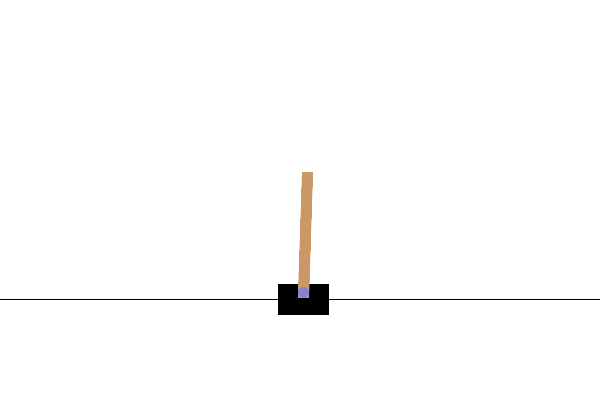

In [ ]:
import gymnasium as gym
env = gym.make("CartPole-v1", render_mode="rgb_array")
g = GIFMaker() # visualization
observation, info = env.reset(seed=42)
for i in range(500):
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)
    # print(i, action, observation, reward)
    g.append(env.render()) # save one frame
    if terminated or truncated:
        observation, info = env.reset()
        break
g.display() # show GIF animation
env.close()

## Env2 MountainCar-v0
Detailed information of this environment: https://gymnasium.farama.org/environments/classic_control/mountain_car/

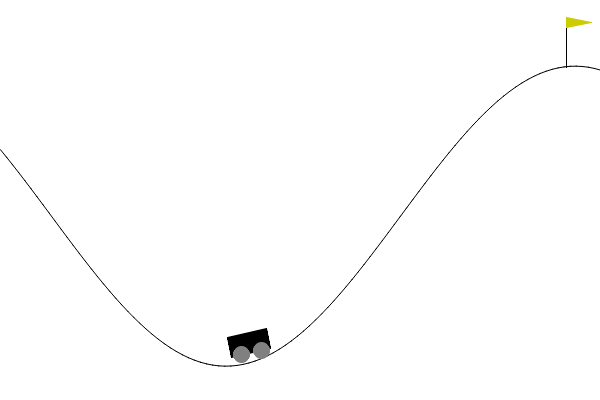

In [ ]:
env = gym.make("MountainCar-v0", render_mode="rgb_array")

observation, info = env.reset(seed=42)
g = GIFMaker()
for i in range(200):
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)
    # print(i, action, observation, reward)
    g.append(env.render())
    if terminated or truncated:
        observation, info = env.reset()
        break
g.display()
env.close()

## Discretization
These environments are originally with continuous state spaces. We need to discretize them so we can apply (tabluar) MC and Q-Learning to them. Discretization is about mapping a continuous value to discrete bins and use the integer index of that bin to represent it.

For example: state (1,7, -2.3). We have bins for the first value (0, 1, 2) and for the second value (-3, 0, 3). Then we can discretize the state to (1, 0), which corresponding to the index (0-start) of the bins each state value falls into. If the state is (0.3, 2.9), we get discretized state (0, 1).

See also: https://numpy.org/doc/stable/reference/generated/numpy.digitize.html

You are encouraged to explore how different numbers of discretized states affect your algorithm performance.

**CartPole**:
- State: reccomended to have **3 to 10** discretized values for each value in the state. The state in CartPole has 4 values, corresponding to: cart position, velocity, pole angle, angular velocity. We will discretize individually for them. For example, you may have 3 discretized for cart position, 5 for velocity, and so on.
- Action: there are **2** actions:
 * 0: left
 * 1: right

**MountainCar**:
- State: reccomended to have **5 to 15** discretized values for each value in the state. The state in MountainCar has 2 values, corresponding to the position and velocity of the car.
- Action: there are **3** actions:
 * 0: Accelerate to the left
 * 1: Don’t accelerate
 * 2: Accelerate to the right

In [ ]:
import math
import numpy as np
from os import stat_result
import matplotlib.pyplot as plt
from tqdm import tqdm
class Discretizer():
    def __init__(
        self,
        min_state,
        max_state,
        num_states_each_dim,
        num_actions
    ):
        assert len(min_state) == len(max_state)
        assert len(min_state) == len(num_states_each_dim)
        self.min_state = min_state
        self.max_state = max_state
        self.num_states_each_dim = num_states_each_dim
        self.num_actions = num_actions
        self.bins = None
        self.build_bins()

    def build_bins(self):
        self.bins = []
        state_dim = len(self.min_state)
        for i in range(state_dim):
            bin = np.linspace(self.min_state[i], self.max_state[i], num=self.num_states_each_dim[i])[:-1]
            self.bins.append(bin)
        # print ("bins", [len(b) for b in self.bins])

    def discretize(self, state: np.ndarray) -> np.ndarray:
        state = np.clip(state, self.min_state, self.max_state)
        discretized_state = []
        for i in range(0, len(state)):
            discretized = np.digitize(state[i], self.bins[i])
            discretized_state.append(discretized)
        # print (discretized_state)
        discretized_state = np.array(discretized_state, dtype=int)
        return discretized_state

cartpole_discretizer = Discretizer(
    min_state = [-4.8, -5.0, -0.418, -5.0],   #min values for cart position, velocity, pole angle, angular velocity
    max_state = [4.8, 5.0, 0.418, 5.0],       #max values for cart position, velocity, pole angle, angular velocity
    num_states_each_dim = [3, 8, 10, 7],     # number of discrized states for position, velocity, pole angle, angular velocity, a python list of integers []
    num_actions = 2,             # number of actions: left or right

)

mountaincar_discretizer = Discretizer(
    min_state = [-1.2, -0.07],              # min values for position and veolcity as per the official doc
    max_state = [0.6, 0.07],                # max values for position and veolcity as per the official doc
    num_states_each_dim = [8,12],        # number of discretized states for position and velocity each, , a python list of integers []
    num_actions = 3,                     # num of actions: left , stay , right
)

##Monte Carlo

Implemented a tabular MC, with epilion-soft policy.

In [ ]:
class MonteCarlo():
    def __init__(
        self,
        env,          # environment
        env_name,     # a string, the name of the environment
        discretizer,  # discretizer,
        eps=0.1,      # for eps-greedy
      ):

        self.env = env                                       # set env
        self.env_name = env_name                             # set env name
        self.eps = eps                                       # epsilon for epsion greedy
        self.mode = "update"                                 # mode to switch between update and evaluation of policy
        self.gif_maker = GIFMaker()                          # for visualizeation

        self.discretizer = discretizer                                # discretizer used to dicretize the observation
        self.state_dim = self.discretizer.num_states_each_dim         # get dimensions of discretized obersvation from helper
        self.action_dim = self.discretizer.num_actions                # get num of actions from helper

        # The Q-table (or action-value function) dimensions. It combines the state and action dimensions.
        self.q_dim = tuple(list(self.state_dim) + [self.action_dim]) # q function dimenstion is state_dim x action_dim

        # Initializing the Q-table with zeros. Every state-action pair has an initial estimated value of 0.
        # As the agent interacts with the environment, these values will be updated based on received rewards and estimates of future rewards.
        self.q = np.zeros(self.q_dim) # initialize q function, an nparray in the shape of self.q_dim

        # This counter will keep track of the number of times each state-action pair in the Q-table has been visited.
        # In the Monte Carlo method, each state-action pair's value will be an average of all the returns following that pair.
        self.counter = np.zeros(self.q_dim) # counter used to track number of updates a particular index in q function, will be used in averaging returns
                                            # an nparray in the shape of self.q_dim, initialized by all zeros

        # Initializing the policy to be a uniform distribution.
        # This means that, initially, the agent has no preference for any action in any state and will select actions randomly.
        self.policy = np.full(self.q_dim, 1.0 / self.action_dim) # inital policy is uniform distribution, an nparray in the shape of self.q_dim.
                                                                 # the last dimension (which corresponding to all actions) should have sum=1 (representing probability)

        # This list will store all the states that the agent visits during an episode.
        # This is important for the Monte Carlo method because at the end of an episode,
        # the agent will go back through this list and update the Q-values for each state-action pair based on the total return from that state onward.
        self.visited_states = []      # history of visited states. A python list. Should be cleared after each episode
        print(f"Q function dimensions for {env_name}: {self.q_dim}")



    def reset_counter(self):                                 # used to reset counter, but not called in current implementation
        self.counter = np.zeros(self.q_dim)

    # visits next state and update the average return for a starting state recursively
    def visit_next_state(self, state):
        discretized_state = self.discretizer.discretize(state) # convert the current state to discrete
        self.visited_states.append(discretized_state) # put the discretized state in the visited state history
        p = self.policy[tuple(discretized_state)] # get the policy (probability) corresponding to that state

        if self.mode == "update":
            action = np.random.choice(self.action_dim, p=p) # if mode is update, follow epsion policy according to policy p. You can use np.random.choice. The action should be an integer for example 0
        elif self.mode == "eval" or self.mode == "vis":
            action = np.argmax(p) # if during evaluation pick the best action, according to p. The action should be an integer for example 0

        next_state, reward, terminated, truncated, info = self.env.step(action)     # take the selected action and move to next state

        if self.mode == "vis":
            self.g.append(self.env.render())                                        # render if visualization

        if terminated or truncated:
            return reward # if terminated return current reward

        else:
            # ====Please write your codes here======
            future_reward = self.visit_next_state(next_state) # call visit next state recursively to continue episode and get cumulative future reward
            reward = reward + future_reward # reward for current state action is immediate reward + cumulative future reward
            index_q = tuple(list(discretized_state) + [action]) # index into q function, according to state and action
            self.counter[index_q] += 1 # increment state action counter, this is used for calculating the mean

            if self.mode == "update":
                self.q[index_q] = (self.q[index_q] * (self.counter[index_q] - 1) + reward) / self.counter[index_q] # update the q value of state, using the average value of all the returns it ever seens

            return reward # return the cumulative reward corresponding to "state"

    # run for one episode
    def run_one_episode(self):
        state, info = self.env.reset()
        r = self.visit_next_state(state)
        return r

    # update policy based on new q function
    def update_policy(self):
        vs = self.visited_states
        for s in vs: # for each state in visited states
          best_action = np.argmax(self.q[tuple(s)]) # get best action based on q function and update it
          for a in range(self.action_dim):
              if a == best_action:
                  self.policy[tuple(s)][a] = 1 - self.eps + (self.eps / self.action_dim)
              else:
                  self.policy[tuple(s)][a] = self.eps / self.action_dim
          # Updating self.policy based on epsilon soft policy


    # policy update
    def update(self):
        self.mode = "update"
        r = self.run_one_episode()    # run one episode, update q function
        self.update_policy()          # update policy
        self.visited_states = []

    # policy evaluation for n episodes
    def eval(self, n):
        rewards = []
        self.mode = "eval"
        state, info = self.env.reset(seed=42)
        for i in range(n):
            r = self.run_one_episode()            # run one episode and get reward
            rewards.append(r)
        return np.mean(rewards)                   # return avergae reward over n episode

    # used for visualization
    def visualize(self):
        self.mode = "vis"
        self.g = GIFMaker()
        r = self.run_one_episode()
        print("Reward on this episode", r)
        if self.env_name != "tic_tac":
            self.g.display()

    # the main fucntion called to update policy and evaluate
    def execute(self, total_ep=5000, eval_freq=100, eval_ep=100):
        rewards = []   #used to track polciy evaluation across runs
        episodes = []  #number of episodes used to update policy
        self.reset_counter()

        prog_bar = tqdm(range(0, total_ep))
        for i in prog_bar:
            self.update()                      # update
            if (i+1) % eval_freq == 0:      # evaluate using eval_ep episodes every eval_freq policy updates
                reward = self.eval(eval_ep)
                rewards.append(reward)
                episodes.append(i)
        # print (episodes, rewards)
        plt.plot(episodes, rewards)   #plot evaluation reward vs episodes
        plt.xlabel('episodes')
        plt.ylabel('Rewards')
        plt.title('Monte carlo on '+self.env_name)
        plt.show()


Q function dimensions for CartPole: (3, 8, 10, 7, 2)


100%|██████████| 800/800 [00:28<00:00, 28.47it/s]


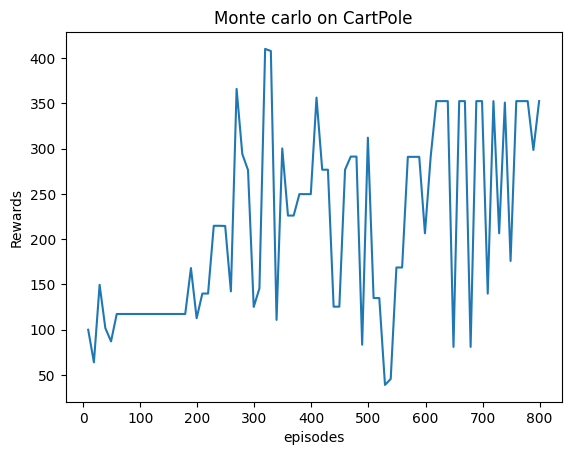

In [ ]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
mc_cartpole = MonteCarlo(env, "CartPole", cartpole_discretizer, eps=.25) # you can explore different eps (epsilon values)
mc_cartpole.execute(total_ep=800, eval_freq=10, eval_ep=10) # This will draw the reward vs. training reward plot for you. You can change differnet total_ep (total training episodes)

Reward on this episode 280.0


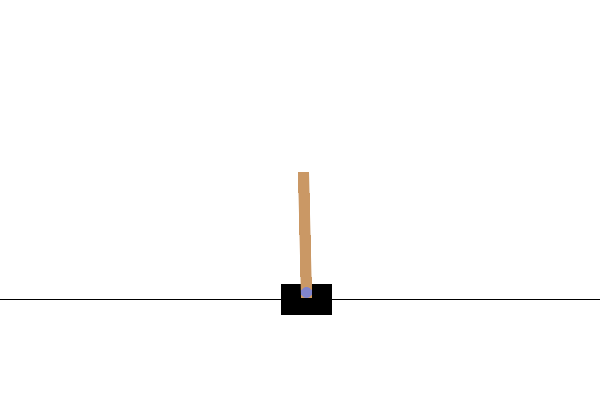

In [ ]:
mc_cartpole.visualize()

In [ ]:
final_evaluation_episodes = 100
avg_reward_cartpole = mc_cartpole.eval(final_evaluation_episodes)
print(f"Average reward for CartPole: {avg_reward_cartpole}")

Average reward for CartPole: 324.62


Q function dimensions for MountainCar: (8, 12, 3)


100%|██████████| 3000/3000 [01:24<00:00, 35.65it/s]


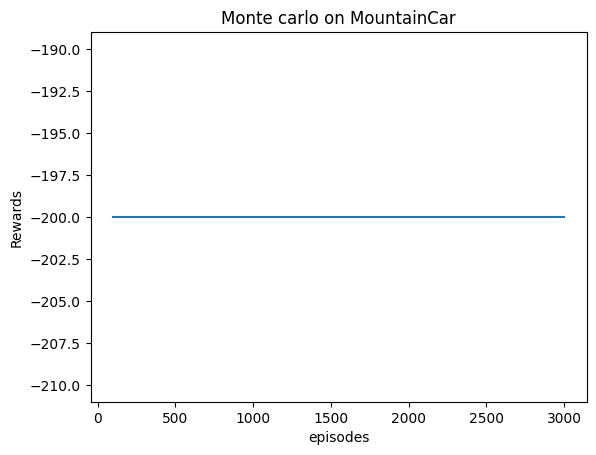

In [ ]:
env = gym.make("MountainCar-v0", render_mode="rgb_array")
mc_mountaincar = MonteCarlo(env, "MountainCar", mountaincar_discretizer, eps=.4) # you can explore different eps (epsilon values) and observe how it affects the learning
mc_mountaincar.execute(total_ep=3000, eval_freq=100, eval_ep=10) # This will draw the plot for you. You can change differnet total_ep (total training episodes)

Reward on this episode -200.0


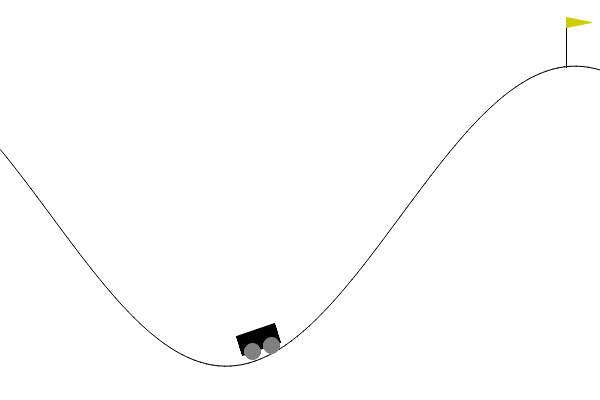

In [ ]:
mc_mountaincar.visualize()

In [ ]:
avg_reward_mountaincar = mc_mountaincar.eval(final_evaluation_episodes)
print(f"Average reward for MountainCar over: {avg_reward_mountaincar}")

Average reward for MountainCar over: -200.0


##Q-Learning


In [ ]:
import numpy as np

class QLearning():
    def __init__(
        self,
        env,
        env_name,
        discretizer,
        eps=0.1
    ):
        self.env = env                                       # set env
        self.env_name = env_name                             # set env name
        self.eps = eps                                       # epsilon for epsion greedy
        self.mode = "update"                                 # mode to switch between update and evaluation of policy
        self.gif_maker = GIFMaker()                          # for visualizeation

        self.discretizer = discretizer                                # discretizer used to dicretize the observation
        self.state_dim = self.discretizer.num_states_each_dim         # get dimensions of discretized obersvation from helper
        self.action_dim = self.discretizer.num_actions                # get num of actions from helper

        # The Q-table (or action-value function) dimensions. It combines the state and action dimensions.
        self.q_dim = tuple(list(self.state_dim) + [self.action_dim]) # q function dimenstion is state_dim x action_dim

        # Initializing the Q-table with zeros. Every state-action pair has an initial estimated value of 0.
        # As the agent interacts with the environment, these values will be updated based on received rewards and estimates of future rewards.
        self.q = np.zeros(self.q_dim) # initialize q function, an nparray in the shape of self.q_dim

        # Initializing the policy to be a uniform distribution.
        # This means that, initially, the agent has no preference for any action in any state and will select actions randomly.
        self.policy = np.full(self.q_dim, 1.0 / self.action_dim)

        self.alpha = 0.1  # learning rate, can be set as needed
        self.gamma = 0.99  # discount factor, can be set as needed
        print(f"Q function dimensions for {env_name}: {self.q_dim}")



    # used to visit next state
    def visit_next_state(self, state):
        # Initialize total reward for the episode
        total_reward = 0
        terminated = False

        while not terminated:
            # Discretize the given state.
            discretized_state = self.discretizer.discretize(state)

            # Epsilon-greedy action selection.
            if self.mode == "update" and np.random.rand() < self.eps:  # Exploration in "update" mode with probability epsilon.
                action = np.random.choice(self.action_dim)
            else:  # Exploitation.
                action = np.argmax(self.q[tuple(discretized_state)])

            # Execute the chosen action in the environment.
            next_state, reward, terminated, truncated, info = self.env.step(action)

            # Add the reward to the total reward
            total_reward += reward

            # Discretize the resulting next state.
            discretized_next_state = self.discretizer.discretize(next_state)

            # Q-learning update.
            best_next_q_value = np.max(self.q[tuple(discretized_next_state)])
            current_q_value = self.q[tuple(discretized_state) + (action,)]
            self.q[tuple(discretized_state) + (action,)] = current_q_value + self.alpha * (reward + self.gamma * best_next_q_value - current_q_value)

            # Update the current state
            state = next_state

            # If in visualization mode, add the current frame to self.g.
            if self.mode == "vis":
                self.g.append(self.env.render())

        return total_reward

    # update policy based on new q function
    def update_policy(self):
        # QLearning does not necessarily need to update Q function, but for the sake of completeness.
        self.policy = np.argmax(self.q, axis=-1)


    # run for one episode
    def run_one_episode(self):
        state, info = self.env.reset()
        r = self.visit_next_state(state)
        return r

    # policy update
    def update(self):
        self.mode = "update"
        self.observation, self.info = self.env.reset()
        r = self.run_one_episode()         # run one episode, update q function
        self.update_policy()               # update policy

    # policy evaluation for n episodes
    def eval(self, n):
        rewards = []
        self.mode = "eval"
        state, info = self.env.reset(seed=42)
        for i in range(n):
            r = self.run_one_episode()            # run one episode and get reward
            rewards.append(r)
        return np.mean(rewards)                   # return avergae reward over n episode

    # used for visualization
    def visualize(self):
        r = 0
        self.mode = "vis"
        self.g = GIFMaker()
        r = r + self.run_one_episode()
        print("Reward on vis episode", r)
        if self.env_name != "tic_tac":
            self.g.display()

    # the main fucntion called to update policy and evaluate for niter of outer iterations
    def execute(self, total_ep=5000, eval_freq=100, eval_ep=100):
        rewards = []   # used to track polciy evaluation across runs
        episodes = []  # number of episodes used to update policy

        prog_bar = tqdm(range(0, total_ep))
        for i in prog_bar:
            self.update()                      # update
            if (i+1) % eval_freq == 0:      # evaluate using eval_ep episodes every eval_freq policy updates
                reward = self.eval(eval_ep)
                rewards.append(reward)
                episodes.append(i)
        # print (episodes, rewards)
        plt.plot(episodes, rewards)   # plot evaluation reward vs episodes
        plt.xlabel('episodes')
        plt.ylabel('Rewards')
        plt.title('Q Learning on '+self.env_name)
        plt.show()


Q function dimensions for CartPole: (3, 8, 10, 7, 2)


100%|██████████| 1200/1200 [00:16<00:00, 70.70it/s]


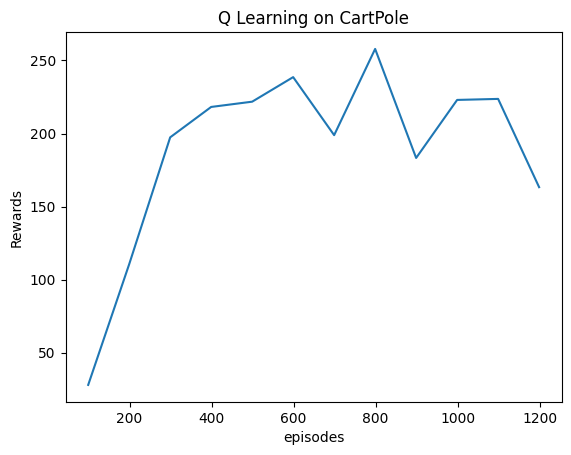

In [ ]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
ql_cartpole = QLearning(env, "CartPole", cartpole_discretizer, eps=0.45) # you can explore different eps (epsilon values) and observe how it affects the learning
ql_cartpole.execute(total_ep=1200, eval_freq=100, eval_ep=10) # This will draw the plot for you. You can change differnet total_ep (total training episodes)

Reward on vis episode 164.0


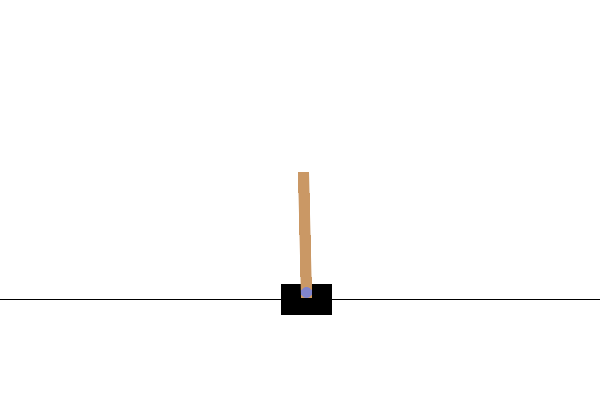

In [ ]:
ql_cartpole.visualize()

In [ ]:
final_evaluation_episodes = 100
average_reward = ql_cartpole.eval(final_evaluation_episodes)
# Print out the average reward
print(f"Average reward for cartpole: {average_reward}")

Average reward for cartpole: 201.23


Q function dimensions for MountainCar: (8, 12, 3)


100%|██████████| 800/800 [00:51<00:00, 15.39it/s]


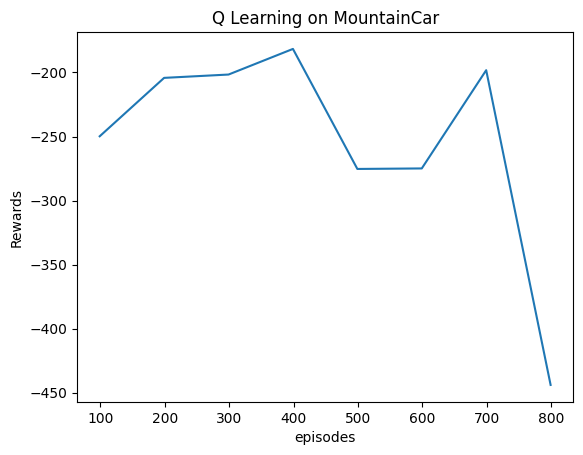

In [ ]:
env = gym.make("MountainCar-v0", render_mode="rgb_array")
ql_mountaincar = QLearning(env, "MountainCar", mountaincar_discretizer, eps=0.08) # you can explore different eps (epsilon values) and observe how it affects the learning
ql_mountaincar.execute(total_ep=800, eval_freq=100, eval_ep=10) # This will draw the plot for you. You can change differnet total_ep (total training episodes)

Reward on vis episode -163.0


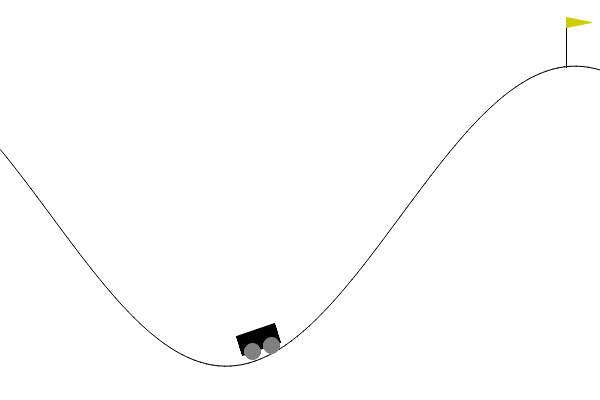

In [ ]:
ql_mountaincar.visualize()

In [ ]:
final_evaluation_episodes = 200
average_reward_mountaincar = ql_mountaincar.eval(final_evaluation_episodes)
# Print out the average reward for the "MountainCar" environment
print(f"Average reward for MountainCar: {average_reward_mountaincar}")

Average reward for MountainCar: -206.78
